In [1]:
#IMPORTS

#File IO
import os
import glob

#Data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn.functional as F
from segmentation_models_pytorch import Unet

#Scikit learn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, r2_score

#Misc
from tqdm import tqdm


In [2]:
#HYPERPARMETERS

train_proportion = .8
val_proportion = .1

batch_size = 128
learning_rate = .00002
num_epochs = 100

In [3]:
#CREATE DATASET

dataset = torch.load("cod_unet_dataset.pt", weights_only=False)

In [4]:
#CREATE DATALOADERS

train_size = int(train_proportion * len(dataset))
val_size = int(val_proportion * len(dataset))
test_size = len(dataset) - train_size - val_size

generator = torch.Generator().manual_seed(1)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=generator)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
#CREATE MODEL

model = Unet(
    encoder_name="resnet34",
    in_channels=16,
    classes=1,
    activation=None
)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

In [6]:
#TRAIN and EVALUATE FUNCTIONS

def train(model, train_loader):
    model.train()
    train_loss = 0
    all_preds = []
    all_labels = []

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        all_preds.append(outputs.detach().cpu().numpy())
        all_labels.append(labels.cpu().numpy())

    avg_loss = train_loss / len(train_loader)

    y_true = np.concatenate(all_labels).ravel()
    y_pred = np.concatenate(all_preds).ravel()
    r2 = r2_score(y_true, y_pred)

    return avg_loss, r2


def eval(model, val_loader):
    model.eval()
    val_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            all_preds.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    avg_loss = val_loss / len(val_loader)
    y_true = np.concatenate(all_labels).ravel()
    y_pred = np.concatenate(all_preds).ravel()
    r2 = r2_score(y_true, y_pred)

    return avg_loss, r2


In [7]:
#TRAIN MODEL

for e in range(1, num_epochs+1):
    train_loss, train_acc = train(model, train_loader)
    val_loss, val_acc = eval(model, val_loader)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch: {e} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

100%|██████████| 94/94 [00:12<00:00,  7.61it/s]


Epoch: 1 | Train Loss: 1.4041 | Train Acc: -0.2396 | Val Loss: 0.9665 | Val Acc: 0.1342


100%|██████████| 94/94 [00:10<00:00,  9.09it/s]


Epoch: 2 | Train Loss: 0.7888 | Train Acc: 0.3037 | Val Loss: 0.6600 | Val Acc: 0.4096


100%|██████████| 94/94 [00:10<00:00,  8.56it/s]


Epoch: 3 | Train Loss: 0.5967 | Train Acc: 0.4736 | Val Loss: 0.5626 | Val Acc: 0.4969


100%|██████████| 94/94 [00:12<00:00,  7.57it/s]


Epoch: 4 | Train Loss: 0.5066 | Train Acc: 0.5531 | Val Loss: 0.4938 | Val Acc: 0.5581


100%|██████████| 94/94 [00:11<00:00,  8.33it/s]


Epoch: 5 | Train Loss: 0.4568 | Train Acc: 0.5970 | Val Loss: 0.4808 | Val Acc: 0.5696


100%|██████████| 94/94 [00:11<00:00,  8.18it/s]


Epoch: 6 | Train Loss: 0.4266 | Train Acc: 0.6238 | Val Loss: 0.4914 | Val Acc: 0.5602


100%|██████████| 94/94 [00:11<00:00,  8.12it/s]


Epoch: 7 | Train Loss: 0.4060 | Train Acc: 0.6420 | Val Loss: 0.4270 | Val Acc: 0.6176


100%|██████████| 94/94 [00:10<00:00,  8.64it/s]


Epoch: 8 | Train Loss: 0.3895 | Train Acc: 0.6564 | Val Loss: 0.4337 | Val Acc: 0.6118


100%|██████████| 94/94 [00:11<00:00,  8.40it/s]


Epoch: 9 | Train Loss: 0.3770 | Train Acc: 0.6677 | Val Loss: 0.4036 | Val Acc: 0.6387


100%|██████████| 94/94 [00:11<00:00,  8.31it/s]


Epoch: 10 | Train Loss: 0.3631 | Train Acc: 0.6797 | Val Loss: 0.3981 | Val Acc: 0.6438


100%|██████████| 94/94 [00:11<00:00,  8.48it/s]


Epoch: 11 | Train Loss: 0.3533 | Train Acc: 0.6882 | Val Loss: 0.4180 | Val Acc: 0.6265


100%|██████████| 94/94 [00:10<00:00,  8.75it/s]


Epoch: 12 | Train Loss: 0.3447 | Train Acc: 0.6961 | Val Loss: 0.4025 | Val Acc: 0.6396


100%|██████████| 94/94 [00:10<00:00,  8.85it/s]


Epoch: 13 | Train Loss: 0.3393 | Train Acc: 0.7008 | Val Loss: 0.3761 | Val Acc: 0.6633


100%|██████████| 94/94 [00:10<00:00,  9.01it/s]


Epoch: 14 | Train Loss: 0.3309 | Train Acc: 0.7082 | Val Loss: 0.3868 | Val Acc: 0.6535


100%|██████████| 94/94 [00:11<00:00,  8.51it/s]


Epoch: 15 | Train Loss: 0.3249 | Train Acc: 0.7134 | Val Loss: 0.3694 | Val Acc: 0.6692


100%|██████████| 94/94 [00:10<00:00,  8.86it/s]


Epoch: 16 | Train Loss: 0.3171 | Train Acc: 0.7202 | Val Loss: 0.3658 | Val Acc: 0.6725


100%|██████████| 94/94 [00:11<00:00,  8.44it/s]


Epoch: 17 | Train Loss: 0.3126 | Train Acc: 0.7241 | Val Loss: 0.3677 | Val Acc: 0.6709


100%|██████████| 94/94 [00:11<00:00,  8.34it/s]


Epoch: 18 | Train Loss: 0.3097 | Train Acc: 0.7267 | Val Loss: 0.3582 | Val Acc: 0.6792


100%|██████████| 94/94 [00:11<00:00,  8.34it/s]


Epoch: 19 | Train Loss: 0.3055 | Train Acc: 0.7306 | Val Loss: 0.3796 | Val Acc: 0.6601


100%|██████████| 94/94 [00:11<00:00,  8.53it/s]


Epoch: 20 | Train Loss: 0.3016 | Train Acc: 0.7339 | Val Loss: 0.3567 | Val Acc: 0.6806


100%|██████████| 94/94 [00:10<00:00,  8.93it/s]


Epoch: 21 | Train Loss: 0.2983 | Train Acc: 0.7369 | Val Loss: 0.3542 | Val Acc: 0.6828


100%|██████████| 94/94 [00:10<00:00,  8.92it/s]


Epoch: 22 | Train Loss: 0.2940 | Train Acc: 0.7407 | Val Loss: 0.3486 | Val Acc: 0.6881


100%|██████████| 94/94 [00:10<00:00,  8.90it/s]


Epoch: 23 | Train Loss: 0.2909 | Train Acc: 0.7435 | Val Loss: 0.3490 | Val Acc: 0.6877


100%|██████████| 94/94 [00:10<00:00,  8.94it/s]


Epoch: 24 | Train Loss: 0.2879 | Train Acc: 0.7462 | Val Loss: 0.3469 | Val Acc: 0.6892


100%|██████████| 94/94 [00:10<00:00,  8.61it/s]


Epoch: 25 | Train Loss: 0.2848 | Train Acc: 0.7489 | Val Loss: 0.3370 | Val Acc: 0.6983


100%|██████████| 94/94 [00:11<00:00,  8.25it/s]


Epoch: 26 | Train Loss: 0.2818 | Train Acc: 0.7516 | Val Loss: 0.3450 | Val Acc: 0.6913


100%|██████████| 94/94 [00:10<00:00,  8.81it/s]


Epoch: 27 | Train Loss: 0.2789 | Train Acc: 0.7542 | Val Loss: 0.3367 | Val Acc: 0.6985


100%|██████████| 94/94 [00:10<00:00,  8.68it/s]


Epoch: 28 | Train Loss: 0.2771 | Train Acc: 0.7554 | Val Loss: 0.3478 | Val Acc: 0.6886


100%|██████████| 94/94 [00:11<00:00,  8.39it/s]


Epoch: 29 | Train Loss: 0.2746 | Train Acc: 0.7577 | Val Loss: 0.3422 | Val Acc: 0.6938


100%|██████████| 94/94 [00:10<00:00,  8.72it/s]


Epoch: 30 | Train Loss: 0.2763 | Train Acc: 0.7562 | Val Loss: 0.3688 | Val Acc: 0.6696


100%|██████████| 94/94 [00:10<00:00,  8.71it/s]


Epoch: 31 | Train Loss: 0.2713 | Train Acc: 0.7608 | Val Loss: 0.3344 | Val Acc: 0.7006


100%|██████████| 94/94 [00:10<00:00,  8.93it/s]


Epoch: 32 | Train Loss: 0.2697 | Train Acc: 0.7621 | Val Loss: 0.3332 | Val Acc: 0.7016


100%|██████████| 94/94 [00:10<00:00,  8.96it/s]


Epoch: 33 | Train Loss: 0.2650 | Train Acc: 0.7664 | Val Loss: 0.3278 | Val Acc: 0.7066


100%|██████████| 94/94 [00:10<00:00,  8.86it/s]


Epoch: 34 | Train Loss: 0.2643 | Train Acc: 0.7668 | Val Loss: 0.3233 | Val Acc: 0.7108


100%|██████████| 94/94 [00:11<00:00,  8.51it/s]


Epoch: 35 | Train Loss: 0.2633 | Train Acc: 0.7678 | Val Loss: 0.3263 | Val Acc: 0.7080


100%|██████████| 94/94 [00:10<00:00,  8.86it/s]


Epoch: 36 | Train Loss: 0.2639 | Train Acc: 0.7673 | Val Loss: 0.3365 | Val Acc: 0.6988


100%|██████████| 94/94 [00:10<00:00,  8.64it/s]


Epoch: 37 | Train Loss: 0.2583 | Train Acc: 0.7722 | Val Loss: 0.3167 | Val Acc: 0.7163


100%|██████████| 94/94 [00:10<00:00,  8.72it/s]


Epoch: 38 | Train Loss: 0.2573 | Train Acc: 0.7730 | Val Loss: 0.3554 | Val Acc: 0.6817


100%|██████████| 94/94 [00:11<00:00,  8.50it/s]


Epoch: 39 | Train Loss: 0.2565 | Train Acc: 0.7739 | Val Loss: 0.3197 | Val Acc: 0.7136


100%|██████████| 94/94 [00:10<00:00,  8.76it/s]


Epoch: 40 | Train Loss: 0.2538 | Train Acc: 0.7761 | Val Loss: 0.3293 | Val Acc: 0.7053


100%|██████████| 94/94 [00:10<00:00,  8.82it/s]


Epoch: 41 | Train Loss: 0.2537 | Train Acc: 0.7763 | Val Loss: 0.3274 | Val Acc: 0.7069


100%|██████████| 94/94 [00:10<00:00,  8.95it/s]


Epoch: 42 | Train Loss: 0.2515 | Train Acc: 0.7780 | Val Loss: 0.3177 | Val Acc: 0.7157


100%|██████████| 94/94 [00:10<00:00,  8.70it/s]


Epoch: 43 | Train Loss: 0.2505 | Train Acc: 0.7789 | Val Loss: 0.3125 | Val Acc: 0.7201


100%|██████████| 94/94 [00:10<00:00,  8.79it/s]


Epoch: 44 | Train Loss: 0.2503 | Train Acc: 0.7793 | Val Loss: 0.3141 | Val Acc: 0.7189


100%|██████████| 94/94 [00:10<00:00,  8.89it/s]


Epoch: 45 | Train Loss: 0.2478 | Train Acc: 0.7813 | Val Loss: 0.3199 | Val Acc: 0.7135


100%|██████████| 94/94 [00:10<00:00,  8.80it/s]


Epoch: 46 | Train Loss: 0.2462 | Train Acc: 0.7828 | Val Loss: 0.3135 | Val Acc: 0.7193


100%|██████████| 94/94 [00:10<00:00,  8.56it/s]


Epoch: 47 | Train Loss: 0.2451 | Train Acc: 0.7838 | Val Loss: 0.3110 | Val Acc: 0.7216


100%|██████████| 94/94 [00:11<00:00,  8.37it/s]


Epoch: 48 | Train Loss: 0.2436 | Train Acc: 0.7852 | Val Loss: 0.3275 | Val Acc: 0.7074


100%|██████████| 94/94 [00:10<00:00,  8.85it/s]


Epoch: 49 | Train Loss: 0.2415 | Train Acc: 0.7871 | Val Loss: 0.3049 | Val Acc: 0.7270


100%|██████████| 94/94 [00:10<00:00,  8.76it/s]


Epoch: 50 | Train Loss: 0.2431 | Train Acc: 0.7859 | Val Loss: 0.3194 | Val Acc: 0.7141


100%|██████████| 94/94 [00:10<00:00,  8.83it/s]


Epoch: 51 | Train Loss: 0.2410 | Train Acc: 0.7874 | Val Loss: 0.3193 | Val Acc: 0.7142


100%|██████████| 94/94 [00:10<00:00,  8.83it/s]


Epoch: 52 | Train Loss: 0.2421 | Train Acc: 0.7866 | Val Loss: 0.3270 | Val Acc: 0.7074


100%|██████████| 94/94 [00:10<00:00,  8.92it/s]


Epoch: 53 | Train Loss: 0.2390 | Train Acc: 0.7893 | Val Loss: 0.3087 | Val Acc: 0.7239


100%|██████████| 94/94 [00:10<00:00,  8.90it/s]


Epoch: 54 | Train Loss: 0.2371 | Train Acc: 0.7907 | Val Loss: 0.3061 | Val Acc: 0.7260


100%|██████████| 94/94 [00:11<00:00,  8.46it/s]


Epoch: 55 | Train Loss: 0.2370 | Train Acc: 0.7909 | Val Loss: 0.3172 | Val Acc: 0.7161


100%|██████████| 94/94 [00:10<00:00,  8.62it/s]


Epoch: 56 | Train Loss: 0.2366 | Train Acc: 0.7915 | Val Loss: 0.3241 | Val Acc: 0.7098


100%|██████████| 94/94 [00:11<00:00,  8.28it/s]


Epoch: 57 | Train Loss: 0.2342 | Train Acc: 0.7934 | Val Loss: 0.3039 | Val Acc: 0.7278


100%|██████████| 94/94 [00:10<00:00,  8.89it/s]


Epoch: 58 | Train Loss: 0.2318 | Train Acc: 0.7956 | Val Loss: 0.3354 | Val Acc: 0.6996


100%|██████████| 94/94 [00:10<00:00,  8.97it/s]


Epoch: 59 | Train Loss: 0.2317 | Train Acc: 0.7956 | Val Loss: 0.3116 | Val Acc: 0.7210


100%|██████████| 94/94 [00:10<00:00,  9.06it/s]


Epoch: 60 | Train Loss: 0.2340 | Train Acc: 0.7937 | Val Loss: 0.3204 | Val Acc: 0.7133


100%|██████████| 94/94 [00:10<00:00,  9.02it/s]


Epoch: 61 | Train Loss: 0.2313 | Train Acc: 0.7961 | Val Loss: 0.3047 | Val Acc: 0.7271


100%|██████████| 94/94 [00:11<00:00,  7.95it/s]


Epoch: 62 | Train Loss: 0.2281 | Train Acc: 0.7987 | Val Loss: 0.3167 | Val Acc: 0.7167


100%|██████████| 94/94 [00:11<00:00,  8.53it/s]


Epoch: 63 | Train Loss: 0.2294 | Train Acc: 0.7977 | Val Loss: 0.3014 | Val Acc: 0.7303


100%|██████████| 94/94 [00:10<00:00,  8.93it/s]


Epoch: 64 | Train Loss: 0.2273 | Train Acc: 0.7994 | Val Loss: 0.3147 | Val Acc: 0.7181


100%|██████████| 94/94 [00:10<00:00,  8.66it/s]


Epoch: 65 | Train Loss: 0.2286 | Train Acc: 0.7985 | Val Loss: 0.3403 | Val Acc: 0.6955


100%|██████████| 94/94 [00:10<00:00,  8.74it/s]


Epoch: 66 | Train Loss: 0.2269 | Train Acc: 0.7998 | Val Loss: 0.3101 | Val Acc: 0.7226


100%|██████████| 94/94 [00:10<00:00,  8.98it/s]


Epoch: 67 | Train Loss: 0.2263 | Train Acc: 0.8004 | Val Loss: 0.3456 | Val Acc: 0.6903


100%|██████████| 94/94 [00:10<00:00,  8.72it/s]


Epoch: 68 | Train Loss: 0.2245 | Train Acc: 0.8019 | Val Loss: 0.3029 | Val Acc: 0.7291


100%|██████████| 94/94 [00:11<00:00,  8.19it/s]


Epoch: 69 | Train Loss: 0.2223 | Train Acc: 0.8039 | Val Loss: 0.2964 | Val Acc: 0.7353


100%|██████████| 94/94 [00:11<00:00,  8.54it/s]


Epoch: 70 | Train Loss: 0.2221 | Train Acc: 0.8040 | Val Loss: 0.2995 | Val Acc: 0.7320


100%|██████████| 94/94 [00:10<00:00,  8.84it/s]


Epoch: 71 | Train Loss: 0.2210 | Train Acc: 0.8051 | Val Loss: 0.2987 | Val Acc: 0.7326


100%|██████████| 94/94 [00:10<00:00,  8.87it/s]


Epoch: 72 | Train Loss: 0.2210 | Train Acc: 0.8051 | Val Loss: 0.3528 | Val Acc: 0.6843


100%|██████████| 94/94 [00:11<00:00,  8.42it/s]


Epoch: 73 | Train Loss: 0.2220 | Train Acc: 0.8042 | Val Loss: 0.3422 | Val Acc: 0.6938


100%|██████████| 94/94 [00:10<00:00,  8.79it/s]


Epoch: 74 | Train Loss: 0.2228 | Train Acc: 0.8033 | Val Loss: 0.2973 | Val Acc: 0.7340


100%|██████████| 94/94 [00:10<00:00,  8.78it/s]


Epoch: 75 | Train Loss: 0.2192 | Train Acc: 0.8066 | Val Loss: 0.3009 | Val Acc: 0.7305


100%|██████████| 94/94 [00:10<00:00,  9.12it/s]


Epoch: 76 | Train Loss: 0.2178 | Train Acc: 0.8078 | Val Loss: 0.2997 | Val Acc: 0.7319


100%|██████████| 94/94 [00:10<00:00,  9.12it/s]


Epoch: 77 | Train Loss: 0.2168 | Train Acc: 0.8087 | Val Loss: 0.3182 | Val Acc: 0.7154


100%|██████████| 94/94 [00:10<00:00,  9.07it/s]


Epoch: 78 | Train Loss: 0.2179 | Train Acc: 0.8078 | Val Loss: 0.2922 | Val Acc: 0.7385


100%|██████████| 94/94 [00:10<00:00,  8.93it/s]


Epoch: 79 | Train Loss: 0.2162 | Train Acc: 0.8093 | Val Loss: 0.3159 | Val Acc: 0.7173


100%|██████████| 94/94 [00:10<00:00,  8.66it/s]


Epoch: 80 | Train Loss: 0.2156 | Train Acc: 0.8098 | Val Loss: 0.2925 | Val Acc: 0.7385


100%|██████████| 94/94 [00:10<00:00,  8.66it/s]


Epoch: 81 | Train Loss: 0.2138 | Train Acc: 0.8115 | Val Loss: 0.3037 | Val Acc: 0.7281


100%|██████████| 94/94 [00:10<00:00,  8.59it/s]


Epoch: 82 | Train Loss: 0.2141 | Train Acc: 0.8111 | Val Loss: 0.2976 | Val Acc: 0.7334


100%|██████████| 94/94 [00:10<00:00,  8.87it/s]


Epoch: 83 | Train Loss: 0.2128 | Train Acc: 0.8123 | Val Loss: 0.3089 | Val Acc: 0.7236


100%|██████████| 94/94 [00:10<00:00,  8.68it/s]


Epoch: 84 | Train Loss: 0.2124 | Train Acc: 0.8127 | Val Loss: 0.3229 | Val Acc: 0.7108


100%|██████████| 94/94 [00:10<00:00,  8.71it/s]


Epoch: 85 | Train Loss: 0.2110 | Train Acc: 0.8139 | Val Loss: 0.2874 | Val Acc: 0.7428


100%|██████████| 94/94 [00:10<00:00,  8.78it/s]


Epoch: 86 | Train Loss: 0.2113 | Train Acc: 0.8138 | Val Loss: 0.3023 | Val Acc: 0.7295


100%|██████████| 94/94 [00:10<00:00,  8.77it/s]


Epoch: 87 | Train Loss: 0.2105 | Train Acc: 0.8143 | Val Loss: 0.3234 | Val Acc: 0.7104


100%|██████████| 94/94 [00:10<00:00,  8.75it/s]


Epoch: 88 | Train Loss: 0.2121 | Train Acc: 0.8130 | Val Loss: 0.3836 | Val Acc: 0.6572


100%|██████████| 94/94 [00:10<00:00,  8.82it/s]


Epoch: 89 | Train Loss: 0.2121 | Train Acc: 0.8129 | Val Loss: 0.2955 | Val Acc: 0.7356


100%|██████████| 94/94 [00:10<00:00,  8.78it/s]


Epoch: 90 | Train Loss: 0.2092 | Train Acc: 0.8154 | Val Loss: 0.3044 | Val Acc: 0.7277


100%|██████████| 94/94 [00:10<00:00,  8.75it/s]


Epoch: 91 | Train Loss: 0.2096 | Train Acc: 0.8151 | Val Loss: 0.3062 | Val Acc: 0.7261


100%|██████████| 94/94 [00:11<00:00,  8.50it/s]


Epoch: 92 | Train Loss: 0.2075 | Train Acc: 0.8169 | Val Loss: 0.3200 | Val Acc: 0.7139


100%|██████████| 94/94 [00:10<00:00,  8.93it/s]


Epoch: 93 | Train Loss: 0.2070 | Train Acc: 0.8175 | Val Loss: 0.2944 | Val Acc: 0.7365


100%|██████████| 94/94 [00:11<00:00,  8.24it/s]


Epoch: 94 | Train Loss: 0.2068 | Train Acc: 0.8175 | Val Loss: 0.3015 | Val Acc: 0.7306


100%|██████████| 94/94 [00:10<00:00,  8.75it/s]


Epoch: 95 | Train Loss: 0.2064 | Train Acc: 0.8179 | Val Loss: 0.2942 | Val Acc: 0.7367


100%|██████████| 94/94 [00:10<00:00,  8.57it/s]


Epoch: 96 | Train Loss: 0.2059 | Train Acc: 0.8184 | Val Loss: 0.3120 | Val Acc: 0.7206


100%|██████████| 94/94 [00:10<00:00,  8.86it/s]


Epoch: 97 | Train Loss: 0.2067 | Train Acc: 0.8177 | Val Loss: 0.2950 | Val Acc: 0.7362


100%|██████████| 94/94 [00:10<00:00,  8.87it/s]


Epoch: 98 | Train Loss: 0.2044 | Train Acc: 0.8197 | Val Loss: 0.2873 | Val Acc: 0.7430


100%|██████████| 94/94 [00:10<00:00,  8.60it/s]


Epoch: 99 | Train Loss: 0.2038 | Train Acc: 0.8202 | Val Loss: 0.2961 | Val Acc: 0.7352


100%|██████████| 94/94 [00:10<00:00,  8.60it/s]


Epoch: 100 | Train Loss: 0.2033 | Train Acc: 0.8207 | Val Loss: 0.3126 | Val Acc: 0.7202


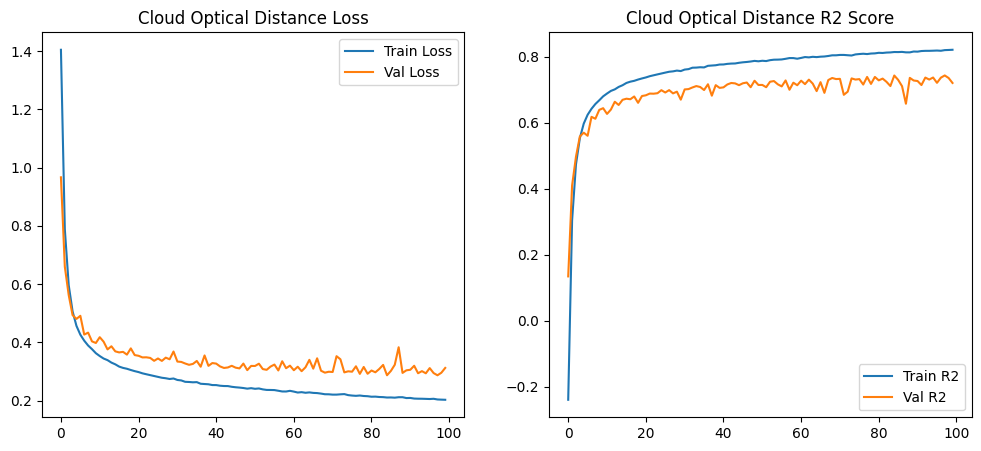

In [8]:
#PLOT LOSS and ACCURACY

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Cloud Optical Distance Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train R2')
plt.plot(val_accuracies, label='Val R2')
plt.title('Cloud Optical Distance R2 Score')
plt.legend()

plt.savefig("./graphs/unet_cod.png")  

plt.show()

In [9]:
#MODEL EVALUATION

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        inputs = inputs.to(device).float()
        labels = labels.to(device)
        outputs = model(inputs)

        all_preds.append(outputs.cpu().numpy().reshape(-1))
        all_labels.append(labels.cpu().numpy().reshape(-1))

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

print("r2:", r2_score(all_labels, all_preds))
print("MSE:", mean_squared_error(all_labels, all_preds))

100%|██████████| 12/12 [00:01<00:00, 11.13it/s]


r2: 0.7172359228134155
MSE: 0.3255302309989929
